In [1]:
!python --version

Python 3.10.11


In [2]:
import torch
import numpy as np
import pandas as pd

In [3]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
dev

device(type='cuda')

In [4]:
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
model = AutoModel.from_pretrained("cointegrated/rubert-tiny2")
model.cuda()

def get_embs(text):
    t = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**{k: v.to(model.device) for k, v in t.items()})
    embs = model_output.last_hidden_state[:, 0, :]
    embs = torch.nn.functional.normalize(embs)
    return embs[0].cpu().numpy()

C:\Users\yeril\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at cointegrated/rubert-tiny2 were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining mode

In [5]:
get_embs('hi').shape

(312,)

In [6]:
def distance(embeddings1, embeddings2, distance_metric=0):
    if distance_metric==0:# Euclidian
        diff = np.subtract(embeddings1, embeddings2)
        dist = np.sum(np.square(diff),0)
    elif distance_metric==1:#cosine
        dot = np.sum(np.multiply(embeddings1, embeddings2), axis=0)
        norm = np.linalg.norm(embeddings1, axis=0) * np.linalg.norm(embeddings2, axis=0)
        similarity = dot / norm
        dist = np.arccos(similarity) / np.pi
    else:
        raise 'Undefined %d' % distance_metric
    return dist

def get_distance(id1, id2):
    label1 = df['label'][id1] if type(id1) == int else id1
    label2 = df['label'][id2] if type(id2) == int else id2
    print(f'distance between {label1} and {label2}: {distance(get_emb(label1), get_emb(label2), distance_metric=1)}')

In [29]:
df = pd.read_csv("C:\\Users\\yeril\\Desktop\\111.csv", sep=';', names=['id', 'label'])
df.head()

,id,label
0,304999800,"ПРОЧЕЕ МЯСО РЫБЫ (ВКЛЮЧАЯ ФАРШ), МОРОЖЕНЫЕ, РЫ..."
1,604909900,"РАСТЕНИЯ ЗАСУШЕННЫЕ, ОБРАБОТАННЫЕ АНТИСЕПТИКОМ..."
2,711400000,ОГУРЦЫ (КОРНИШОНЫ) КОНСЕРВИРОВАННЫЕ ДЛЯ КРАТКО...
3,712909000,"ОВОЩИ СУЩЕННЫЕ, ЧЕСНОК СУШЕННЫЙ ХЛОПЬЯ, МАРКИР..."
4,803901000,"БАНАНЫ СВЕЖИЕ, ЗЕЛЕНЫЕ, СОРТА ""CAVENDISH"", УПА..."


In [30]:
df['label'] = df['label'].str.lower()
df['label'] = df['label'].str.strip()
df['label'] = df['label'].str.replace(r'\s+', ' ')
df['label'] = df['label'].str.replace(r'[^\w\s]+', ' ')

C:\Users\yeril\AppData\Local\Temp\ipykernel_8376\970123699.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['label'] = df['label'].str.replace(r'\s+', ' ')
C:\Users\yeril\AppData\Local\Temp\ipykernel_8376\970123699.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df['label'] = df['label'].str.replace(r'[^\w\s]+', ' ')


In [31]:
len(df['id'].unique())

2610

In [41]:
len(df['label'].unique())

69218

In [43]:
df = df.drop_duplicates()

In [44]:
len(df)

69958

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69958 entries, 0 to 70588
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      69958 non-null  int64 
 1   label   69958 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.6+ MB


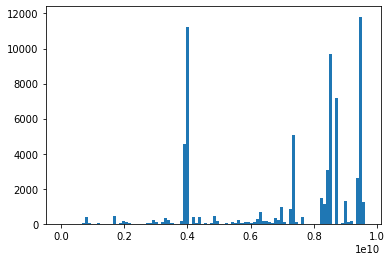

In [45]:
from matplotlib import pyplot as plt 
plt.hist(df['id'], 100)
plt.show()